In [1]:
from __future__ import print_function
import numpy as np

import keras
from keras.datasets import cifar10
from keras.layers import AveragePooling2D, Input, Flatten
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.models import Model
import os

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


Cutout Augmentation

In [0]:
def random_cutout(p=0.5, v_l=0, v_h=255):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img
        
        w = 8
        mid_x = np.random.randint(0, img_w)
        mid_y = np.random.randint(0, img_h)
        
        c = np.random.uniform(v_l, v_h)
        input_img[mid_x - w : mid_x + w, mid_y - w : mid_y + w, :] = c

        return input_img

    return eraser

RESNET20

In [0]:

def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

 

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v2(input_shape, depth, num_classes=10):
    
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model



Data Preparation

In [4]:

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

input_shape = x_train.shape[1:]

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train, X_test, y_train, Y_test = train_test_split(x_train, y_train, stratify=y_train, test_size=0.8)

N = 10

y_train = keras.utils.to_categorical(y_train, N)
y_test = keras.utils.to_categorical(y_test, N)


170500096/170498071 [==============================] - 13s 0us/step


Training Parameters

In [0]:
batch_size = 128 
epochs = 100
#N = 10

n=3
depth = n*6+2
model_type = 'ResNet%dv' % (depth)

Model

In [6]:


model = resnet_v2(input_shape=input_shape, depth=depth)


model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

datagen = ImageDataGenerator(
        preprocessing_function=random_cutout(v_l=0, v_h=1))

datagen.fit(x_train)

plot = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    validation_data=(x_test, y_test),
                    epochs=epochs, verbose=1, workers=4)
             

# Final Scores
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Epoch 1/100
79/79 [==============================] - 21s 271ms/step - loss: 2.2532 - accuracy: 0.3309 - val_loss: 3.0922 - val_accuracy: 0.1457
Epoch 2/100
79/79 [==============================] - 10s 124ms/step - loss: 1.9257 - accuracy: 0.4471 - val_loss: 3.8265 - val_accuracy: 0.1331
Epoch 3/100
79/79 [==============================] - 10s 124ms/step - loss: 1.7491 - accuracy: 0.5021 - val_loss: 2.8337 - val_accuracy: 0.2514
Epoch 4/100
79/79 [==============================] - 10s 124ms/step - loss: 1.6111 - accuracy: 0.5489 - val_loss: 2.5865 - val_accuracy: 0.3055
Epoch 5/100
79/79 [==============================] - 10s 124ms/step - loss: 1.4658 - accuracy: 0.6026 - val_loss: 2.4851 - val_accuracy: 0.3504
Epoch 6/100
79/79 [==============================] - 10s 125ms/step - loss: 1.3882 - accuracy: 0.6290 - val_loss: 1.9698 - val_accuracy: 0.4642
Epoch 7/100
79/79 [==============================] - 10s 124ms/step - loss: 1.2651 - accuracy: 0.6735 - val_loss: 2.1231 - val_accuracy:

Plot : Accuracy

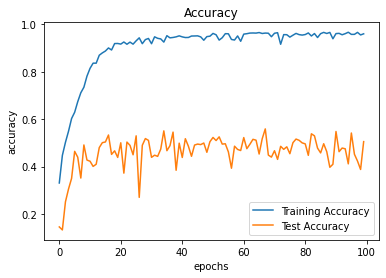

In [9]:

#Display of the accuracy and the loss values
import matplotlib.pyplot as plt

plt.figure(0)
plt.plot(plot.history['accuracy'], label='Training Accuracy')
plt.plot(plot.history['val_accuracy'], label='Test Accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

Plot : Loss

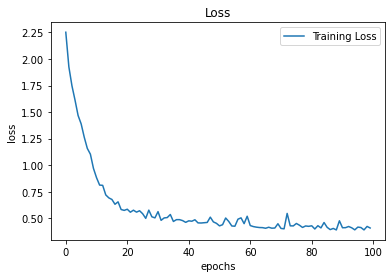

In [10]:
plt.plot(plot.history['loss'], label='Training Loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()